In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:
"""
基本設定
"""
n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 
currency = ["BTC","DASH","ETH","JPY","EUR","AUD"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5803,11746,18352,24381,30580,36862,42796,49202,55343,61231,67401,73733,79985,85727,92344,98128,104693,111029,117077,123701,129808,136084,142402,148336]
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0

epochs = 40
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [6]:
"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        #目前問題設定只有三種設定：前者大(big)-0、後者大(small)-1、一樣(s)-2
        tmp = np.eye((2))
        d = {0:tmp[0],1:tmp[1]}
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small']
HVqtype = ['big','small']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)

In [7]:
"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=5))(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y

def build_tag(conv):
    d = K.int_shape(conv)[1]
    tag = np.zeros((d,1))
    for i in range(d):
        tag[i] = float(int(i%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

In [8]:
"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    cycle = ((currencynum*(currencynum-1))/2)*len(question)*len(qtype)
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    print("reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q_reverse[ii])
            a_trend.append(Test_a_reverse[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q_reverse[ii])
            a_vol.append(Test_a_reverse[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2405 MiB, count=2, average=1202 MiB
[Training model......]
Train on 1112340 samples, validate on 342720 samples
Epoch 1/40
1112340/1112340 [==============================] - 11s 10us/step - loss: 0.7100 - acc: 0.5452 - val_loss: 0.6366 - val_acc: 0.6332
Epoch 2/40
1112340/1112340 [==============================] - 7s 6us/step - loss: 0.6098 - acc: 0.6472 - val_loss: 0.5555 - val_acc: 0.6677
Epoch 3/40
1112340/1112340 [==============================] - 8s 7us/step - loss: 0.5302 - acc: 0.6869 - val_loss: 0.4924 - val_acc: 0.6939
Epoch 4/40
1112340/1112340 [==============================] - 8s 7us/step - loss: 0.4906 - acc: 0.7008 - val_loss: 0.4690 - val_acc: 0.7036
Epoch 5/40
1112340/1112340 [==============================] - 8s 7us/step - loss: 0.4768 - acc: 0.7043 - val_loss: 0.4611 - val_acc: 0.7038
Epoch 6/40
1112340/1112340 

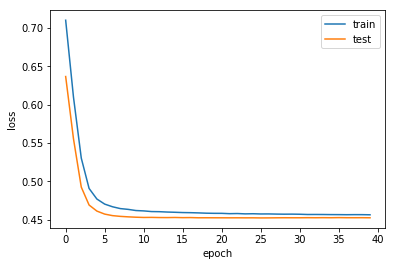

acc:
0.7141386626391212
val_acc:
0.7136350371924435


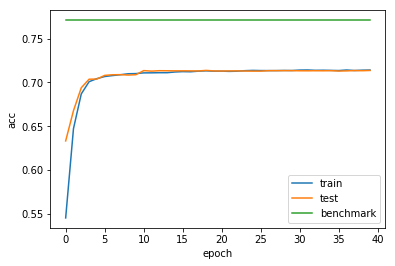

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2436 MiB, count=88, average=27.7 MiB
[Training model......]
Train on 1084260 samples, validate on 389580 samples
Epoch 1/40
1084260/1084260 [==============================] - 10s 10us/step - loss: 0.7310 - acc: 0.5356 - val_loss: 0.6595 - val_acc: 0.6252
Epoch 2/40
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.6411 - acc: 0.6232 - val_loss: 0.6028 - val_acc: 0.6479
Epoch 3/40
1084260/1084260 [==============================] - 7s 6us/step - loss: 0.5676 - acc: 0.6677 - val_loss: 0.5157 - val_acc: 0.6890
Epoch 4/40
1084260/1084260 [==============================] - 8s 7us/step - loss: 0.5046 - acc: 0.6936 - val_loss: 0.4727 - val_acc: 0.7084
Epoch 5/40
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.4807 - acc: 0.7021 - val_loss: 0.4594 - val_acc: 0.7080
Epoch 6/40
1084260/1084260

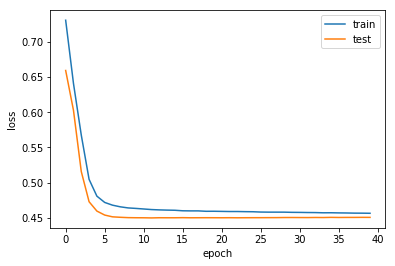

acc:
0.7130697434931383
val_acc:
0.7132963704483924


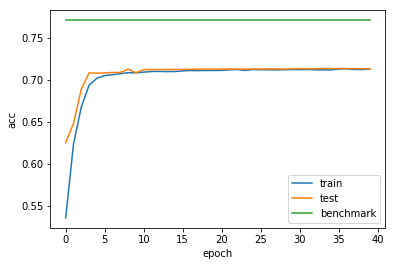

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2495 MiB, count=89, average=28.0 MiB
[Training model......]
Train on 1133640 samples, validate on 375840 samples
Epoch 1/40
1133640/1133640 [==============================] - 11s 10us/step - loss: 0.7062 - acc: 0.5570 - val_loss: 0.6472 - val_acc: 0.6512
Epoch 2/40
1133640/1133640 [==============================] - 7s 6us/step - loss: 0.6136 - acc: 0.6475 - val_loss: 0.5621 - val_acc: 0.6729
Epoch 3/40
1133640/1133640 [==============================] - 7s 6us/step - loss: 0.5351 - acc: 0.6817 - val_loss: 0.5024 - val_acc: 0.6985
Epoch 4/40
1133640/1133640 [==============================] - 7s 6us/step - loss: 0.4934 - acc: 0.6966 - val_loss: 0.4757 - val_acc: 0.7013
Epoch 5/40
1133640/1133640 [==============================] - 7s 7us/step - loss: 0.4773 - acc: 0.7029 - val_loss: 0.4628 - val_acc: 0.7062
Epoch 6/40
1133640/1133640

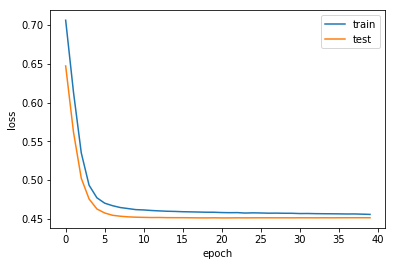

acc:
0.713214953527181
val_acc:
0.710597594528312


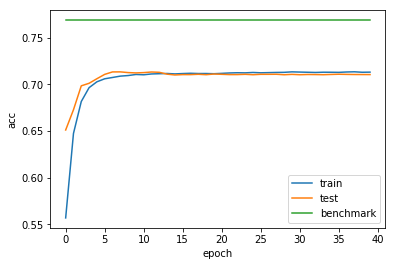

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2438 MiB, count=90, average=27.1 MiB
[Training model......]
Train on 1116780 samples, validate on 358560 samples
Epoch 1/40
1116780/1116780 [==============================] - 11s 10us/step - loss: 0.6965 - acc: 0.5531 - val_loss: 0.6229 - val_acc: 0.6403
Epoch 2/40
1116780/1116780 [==============================] - 7s 6us/step - loss: 0.6024 - acc: 0.6396 - val_loss: 0.5451 - val_acc: 0.6562
Epoch 3/40
1116780/1116780 [==============================] - 7s 6us/step - loss: 0.5255 - acc: 0.6781 - val_loss: 0.4991 - val_acc: 0.6938
Epoch 4/40
1116780/1116780 [==============================] - 7s 7us/step - loss: 0.4888 - acc: 0.6945 - val_loss: 0.4707 - val_acc: 0.7026
Epoch 5/40
1116780/1116780 [==============================] - 7s 6us/step - loss: 0.4746 - acc: 0.6996 - val_loss: 0.4610 - val_acc: 0.7027
Epoch 6/40
1116780/1116780

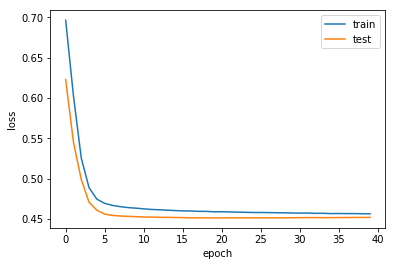

acc:
0.7140367842930628
val_acc:
0.7129769077581893


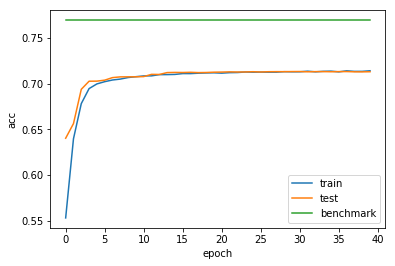

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2521 MiB, count=91, average=27.7 MiB
[Training model......]
Train on 1132620 samples, validate on 393120 samples
Epoch 1/40
1132620/1132620 [==============================] - 11s 10us/step - loss: 0.6957 - acc: 0.5575 - val_loss: 0.6341 - val_acc: 0.6365
Epoch 2/40
1132620/1132620 [==============================] - 8s 7us/step - loss: 0.6058 - acc: 0.6456 - val_loss: 0.5592 - val_acc: 0.6463
Epoch 3/40
1132620/1132620 [==============================] - 7s 7us/step - loss: 0.5373 - acc: 0.6745 - val_loss: 0.5058 - val_acc: 0.6802
Epoch 4/40
1132620/1132620 [==============================] - 7s 7us/step - loss: 0.4981 - acc: 0.6922 - val_loss: 0.4806 - val_acc: 0.7042
Epoch 5/40
1132620/1132620 [==============================] - 7s 6us/step - loss: 0.4813 - acc: 0.7002 - val_loss: 0.4682 - val_acc: 0.7078
Epoch 6/40
1132620/1132620

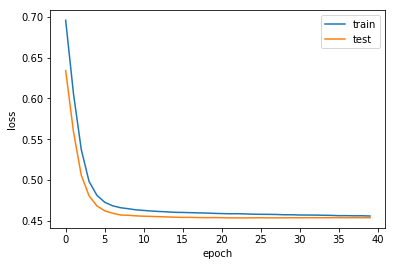

acc:
0.7129937666743734
val_acc:
0.7086996339955949


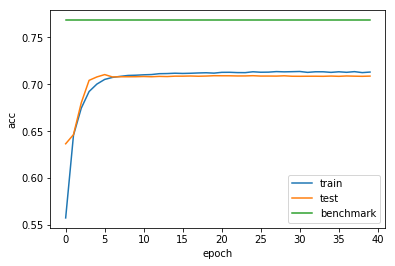

In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 12
tail = 17
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/btc_data_ver2.0.csv',header=None)  # 讀取訓練數據
    btc5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        btc5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/eth_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eth5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eth5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/DASH_data_ver2.0.csv',header=None)  # 讀取訓練數據
    dash5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        dash5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=btc5months[p:p+l]
        Train_data[p,1,:]=dash5months[p:p+l]
        Train_data[p,2,:]=eth5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=aud5months[p:p+l]
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((16,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])
    

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 36, 6)        0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 32, 20)       620         input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 28, 20)       2020        conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 24, 20)       2020        conv1d_14[0][0]                  
__________________________________________________________________________________________________
max_poolin

train_acc:red,test_acc:blue


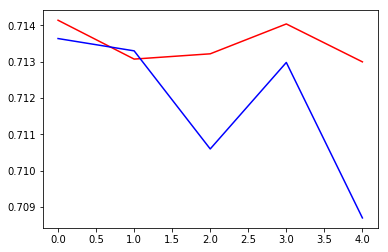

train_loss:red,test_loss:blue


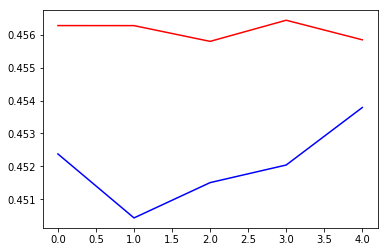

trend:red,vol:blue


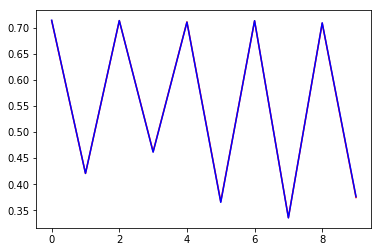

In [10]:
print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()

In [11]:
K.clear_session()

In [8]:
"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    


In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 9
tail = 21
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/btc_data_ver2.0.csv',header=None)  # 讀取訓練數據
    btc5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        btc5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/eth_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eth5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eth5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/DASH_data_ver2.0.csv',header=None)  # 讀取訓練數據
    dash5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        dash5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=btc5months[p:p+l]
        Train_data[p,1,:]=dash5months[p:p+l]
        Train_data[p,2,:]=eth5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=aud5months[p:p+l]
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((16,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2429 MiB, count=2, average=1215 MiB
[Training model......]
Train on 1099080 samples, validate on 370800 samples
Epoch 1/40
1099080/1099080 [==============================] - 11s 10us/step - loss: 0.7060 - acc: 0.5479 - val_loss: 0.6293 - val_acc: 0.6687
Epoch 2/40
1099080/1099080 [==============================] - 7s 6us/step - loss: 0.6124 - acc: 0.6359 - val_loss: 0.5439 - val_acc: 0.6837
Epoch 3/40
1099080/1099080 [==============================] - 7s 6us/step - loss: 0.5420 - acc: 0.6720 - val_loss: 0.4881 - val_acc: 0.6928
Epoch 4/40
1099080/1099080 [==============================] - 7s 7us/step - loss: 0.5031 - acc: 0.6906 - val_loss: 0.4743 - val_acc: 0.7031
Epoch 5/40
1099080/1099080 [==============================] - 7s 7us/step - loss: 0.4881 - acc: 0.6982 - val_loss: 0.4720 - val_acc: 0.7020
Epoch 6/40
1099080/1099080 [

1120920/1120920 [==============================] - 7s 6us/step - loss: 0.4654 - acc: 0.7064 - val_loss: 0.4813 - val_acc: 0.7109
Epoch 15/40
1120920/1120920 [==============================] - 8s 7us/step - loss: 0.4651 - acc: 0.7063 - val_loss: 0.4817 - val_acc: 0.7107
Epoch 16/40
1120920/1120920 [==============================] - 7s 6us/step - loss: 0.4649 - acc: 0.7067 - val_loss: 0.4820 - val_acc: 0.7107
Epoch 17/40
1120920/1120920 [==============================] - 7s 6us/step - loss: 0.4645 - acc: 0.7062 - val_loss: 0.4826 - val_acc: 0.7104
Epoch 18/40
1120920/1120920 [==============================] - 7s 7us/step - loss: 0.4643 - acc: 0.7070 - val_loss: 0.4825 - val_acc: 0.7107
Epoch 19/40
1120920/1120920 [==============================] - 8s 7us/step - loss: 0.4640 - acc: 0.7077 - val_loss: 0.4827 - val_acc: 0.7109
Epoch 20/40
1120920/1120920 [==============================] - 7s 7us/step - loss: 0.4640 - acc: 0.7070 - val_loss: 0.4826 - val_acc: 0.7106
Epoch 21/40
1120920/11209

1095240/1095240 [==============================] - 7s 7us/step - loss: 0.4630 - acc: 0.7097 - val_loss: 0.4872 - val_acc: 0.7100
Epoch 30/40
1095240/1095240 [==============================] - 7s 6us/step - loss: 0.4628 - acc: 0.7099 - val_loss: 0.4873 - val_acc: 0.7100
Epoch 31/40
1095240/1095240 [==============================] - 7s 7us/step - loss: 0.4626 - acc: 0.7100 - val_loss: 0.4876 - val_acc: 0.7100
Epoch 32/40
1095240/1095240 [==============================] - 7s 7us/step - loss: 0.4626 - acc: 0.7101 - val_loss: 0.4877 - val_acc: 0.7098
Epoch 33/40
1095240/1095240 [==============================] - 7s 7us/step - loss: 0.4626 - acc: 0.7098 - val_loss: 0.4879 - val_acc: 0.7097
Epoch 34/40
1095240/1095240 [==============================] - 8s 7us/step - loss: 0.4625 - acc: 0.7102 - val_loss: 0.4880 - val_acc: 0.7102
Epoch 35/40
1095240/1095240 [==============================] - 8s 7us/step - loss: 0.4625 - acc: 0.7107 - val_loss: 0.4885 - val_acc: 0.7099
Epoch 36/40
1095240/10952

1084260/1084260 [==============================] - 11s 10us/step - loss: 0.6825 - acc: 0.5561 - val_loss: 0.6034 - val_acc: 0.6617
Epoch 2/40
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.5819 - acc: 0.6549 - val_loss: 0.5116 - val_acc: 0.6917
Epoch 3/40
1084260/1084260 [==============================] - 7s 6us/step - loss: 0.5210 - acc: 0.6862 - val_loss: 0.4793 - val_acc: 0.7033
Epoch 4/40
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.4942 - acc: 0.6955 - val_loss: 0.4733 - val_acc: 0.7079
Epoch 5/40
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.4821 - acc: 0.6998 - val_loss: 0.4742 - val_acc: 0.7125
Epoch 6/40
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.4757 - acc: 0.7034 - val_loss: 0.4767 - val_acc: 0.7120
Epoch 7/40
1084260/1084260 [==============================] - 7s 6us/step - loss: 0.4718 - acc: 0.7053 - val_loss: 0.4790 - val_acc: 0.7121
Epoch 8/40
1084260/1084260 [=

1133640/1133640 [==============================] - 8s 7us/step - loss: 0.4662 - acc: 0.7084 - val_loss: 0.4785 - val_acc: 0.7134
Epoch 17/40
1133640/1133640 [==============================] - 7s 6us/step - loss: 0.4657 - acc: 0.7075 - val_loss: 0.4791 - val_acc: 0.7135
Epoch 18/40
1133640/1133640 [==============================] - 7s 6us/step - loss: 0.4653 - acc: 0.7086 - val_loss: 0.4793 - val_acc: 0.7133
Epoch 19/40
1133640/1133640 [==============================] - 8s 7us/step - loss: 0.4653 - acc: 0.7087 - val_loss: 0.4792 - val_acc: 0.7135
Epoch 20/40
1133640/1133640 [==============================] - 8s 7us/step - loss: 0.4653 - acc: 0.7090 - val_loss: 0.4789 - val_acc: 0.7135
Epoch 21/40
1133640/1133640 [==============================] - 7s 7us/step - loss: 0.4648 - acc: 0.7083 - val_loss: 0.4792 - val_acc: 0.7138
Epoch 22/40
1133640/1133640 [==============================] - 8s 7us/step - loss: 0.4648 - acc: 0.7090 - val_loss: 0.4795 - val_acc: 0.7136
Epoch 23/40
1133640/11336

1116780/1116780 [==============================] - 7s 7us/step - loss: 0.4628 - acc: 0.7092 - val_loss: 0.4869 - val_acc: 0.7102
Epoch 32/40
1116780/1116780 [==============================] - 7s 6us/step - loss: 0.4629 - acc: 0.7097 - val_loss: 0.4866 - val_acc: 0.7099
Epoch 33/40
1116780/1116780 [==============================] - 7s 7us/step - loss: 0.4629 - acc: 0.7091 - val_loss: 0.4865 - val_acc: 0.7097
Epoch 34/40
1116780/1116780 [==============================] - 7s 6us/step - loss: 0.4630 - acc: 0.7091 - val_loss: 0.4865 - val_acc: 0.7101
Epoch 35/40
1116780/1116780 [==============================] - 7s 7us/step - loss: 0.4628 - acc: 0.7095 - val_loss: 0.4863 - val_acc: 0.7100
Epoch 36/40
1116780/1116780 [==============================] - 8s 7us/step - loss: 0.4627 - acc: 0.7098 - val_loss: 0.4862 - val_acc: 0.7100
Epoch 37/40
1116780/1116780 [==============================] - 7s 6us/step - loss: 0.4625 - acc: 0.7097 - val_loss: 0.4861 - val_acc: 0.7100
Epoch 38/40
1116780/11167

1136160/1136160 [==============================] - 8s 7us/step - loss: 0.5507 - acc: 0.6741 - val_loss: 0.4867 - val_acc: 0.6944
Epoch 4/40
1136160/1136160 [==============================] - 7s 6us/step - loss: 0.5072 - acc: 0.6898 - val_loss: 0.4721 - val_acc: 0.7029
Epoch 5/40
1136160/1136160 [==============================] - 7s 6us/step - loss: 0.4900 - acc: 0.6975 - val_loss: 0.4712 - val_acc: 0.7031
Epoch 6/40
1136160/1136160 [==============================] - 7s 7us/step - loss: 0.4826 - acc: 0.7004 - val_loss: 0.4710 - val_acc: 0.7031
Epoch 7/40
1136160/1136160 [==============================] - 7s 6us/step - loss: 0.4775 - acc: 0.7014 - val_loss: 0.4717 - val_acc: 0.7033
Epoch 8/40
1136160/1136160 [==============================] - 7s 7us/step - loss: 0.4745 - acc: 0.7030 - val_loss: 0.4725 - val_acc: 0.7118
Epoch 9/40
1136160/1136160 [==============================] - 8s 7us/step - loss: 0.4727 - acc: 0.7040 - val_loss: 0.4732 - val_acc: 0.7120
Epoch 10/40
1136160/1136160 [==

1122420/1122420 [==============================] - 8s 7us/step - loss: 0.4653 - acc: 0.7069 - val_loss: 0.4776 - val_acc: 0.7127
Epoch 19/40
1122420/1122420 [==============================] - 7s 6us/step - loss: 0.4650 - acc: 0.7070 - val_loss: 0.4779 - val_acc: 0.7128
Epoch 20/40
1122420/1122420 [==============================] - 8s 7us/step - loss: 0.4651 - acc: 0.7073 - val_loss: 0.4783 - val_acc: 0.7124
Epoch 21/40
1122420/1122420 [==============================] - 8s 7us/step - loss: 0.4648 - acc: 0.7074 - val_loss: 0.4786 - val_acc: 0.7124
Epoch 22/40
1122420/1122420 [==============================] - 8s 7us/step - loss: 0.4644 - acc: 0.7074 - val_loss: 0.4791 - val_acc: 0.7123
Epoch 23/40
1122420/1122420 [==============================] - 7s 7us/step - loss: 0.4643 - acc: 0.7080 - val_loss: 0.4794 - val_acc: 0.7122
Epoch 24/40
1122420/1122420 [==============================] - 7s 7us/step - loss: 0.4642 - acc: 0.7081 - val_loss: 0.4792 - val_acc: 0.7118
Epoch 25/40
1122420/11224

1136100/1136100 [==============================] - 7s 6us/step - loss: 0.4628 - acc: 0.7099 - val_loss: 0.4788 - val_acc: 0.7135
Epoch 34/40
1136100/1136100 [==============================] - 7s 7us/step - loss: 0.4631 - acc: 0.7097 - val_loss: 0.4786 - val_acc: 0.7135
Epoch 35/40
1136100/1136100 [==============================] - 8s 7us/step - loss: 0.4628 - acc: 0.7093 - val_loss: 0.4784 - val_acc: 0.7132
Epoch 36/40
1136100/1136100 [==============================] - 7s 6us/step - loss: 0.4628 - acc: 0.7098 - val_loss: 0.4786 - val_acc: 0.7133
Epoch 37/40
1136100/1136100 [==============================] - 8s 7us/step - loss: 0.4626 - acc: 0.7097 - val_loss: 0.4787 - val_acc: 0.7133
Epoch 38/40
1136100/1136100 [==============================] - 7s 6us/step - loss: 0.4625 - acc: 0.7099 - val_loss: 0.4787 - val_acc: 0.7133
Epoch 39/40
1136100/1136100 [==============================] - 8s 7us/step - loss: 0.4625 - acc: 0.7094 - val_loss: 0.4789 - val_acc: 0.7136
Epoch 40/40
1136100/11361